In [44]:
# importing data manipulation libraries
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import ML tools 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

# configure notebook for inline plotting
%matplotlib inline

# config pandas to display more than 20 columns
pd.set_option('display.max_columns',250)

# set grid style 
sns.set_style('darkgrid')

In [2]:
# load data from file
data = pd.read_csv('./data/match_data_avg_stats.csv', header=0)

# inspect the dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [3]:
# drop matches with "incomplete" or "suspended" status
data = data[data['status'] == 'complete']

In [4]:
# check shape of data
data.shape

(6278, 49)

In [5]:
# Get the shape (number of rows and columns) where the 'team_a_xg_prematch' column is equal to 0
data[data['team_a_xg_prematch']==0].shape

(3609, 49)

In [6]:
# Get the shape (number of rows and columns) where the 'team_b_xg_prematch' column is equal to 0
data[data['team_b_xg_prematch']==0].shape

(3609, 49)

In [7]:
# Get the shape (number of rows and columns) where the 'total_xg_prematch' column is equal to 0
data[data['total_xg_prematch']==0].shape

(3603, 49)

In [8]:
# check entries with values == 0
columns_to_drop = ['team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [9]:
# drop columns with missing values
data.drop(columns=columns_to_drop, inplace=True)

In [10]:
# inspect the first few rows of data dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [11]:
def winningTeam(row):
    # Extracting the goal counts for the home and away teams from the row
    homeGoalCount = row['homeGoalCount']
    awayGoalCount = row['awayGoalCount']
    
    # Checking which team won based on the goal counts
    if homeGoalCount > awayGoalCount:
        return 1  # 1 means home team won
    elif awayGoalCount > homeGoalCount:
        return 2  # 2 means away team won
    else:
        return 0  # 0 indicates a draw


In [12]:
# Apply the winningTeam function to each row of the dataframe
data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)

In [13]:
# check for missing values in the ppg columns
data[data['away_ppg']==0].shape

(0, 47)

In [14]:
data[data['odds_ft_1']==0].shape

(1915, 47)

In [15]:
# check shape of dataframe 
data.shape

(6278, 47)

In [16]:
# drop entries where odds is zero
cleaned_data = data.drop(index=data[data['odds_ft_1']==0].index)

In [17]:
# check size of new dataframe
cleaned_data.shape

(4363, 47)

In [18]:
# inspect column to check that entries with zeros have been dropped
cleaned_data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [19]:
# get dataframe info
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4363 entries, 0 to 6279
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4363 non-null   int64  
 1   homeID                 4363 non-null   int64  
 2   awayID                 4363 non-null   int64  
 3   home_name              4363 non-null   object 
 4   away_name              4363 non-null   object 
 5   date                   4363 non-null   object 
 6   season                 4363 non-null   object 
 7   status                 4363 non-null   object 
 8   homeGoalCount          4363 non-null   int64  
 9   awayGoalCount          4363 non-null   int64  
 10  totalGoalCount         4363 non-null   int64  
 11  team_a_cards_num       4363 non-null   int64  
 12  team_b_cards_num       4363 non-null   int64  
 13  odds_ft_1              4363 non-null   float64
 14  odds_ft_x              4363 non-null   float64
 15  odds_ft_2

In [20]:
# Define a list of columns to be dropped from the DataFrame
columns_to_drop = ['id', 'homeID', 'awayID', 'home_name', 'away_name', 'date', 'season',
                   'status', 'homeGoalCount', 'awayGoalCount', 'totalGoalCount',
                   'team_a_cards_num', 'team_b_cards_num']

# Drop the specified columns from the DataFrame
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

In [21]:
# inspect cleaned dataset to confirm columns were dropped successfully
cleaned_data.head()

,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,3.41,3.19,2.39,1.47,0.53,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,2.45,3.22,3.26,1.74,0.74,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,2.20,3.25,3.80,1.05,0.84,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,3.13,3.36,2.45,2.26,1.74,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,2.49,3.20,3.21,0.95,0.89,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [22]:
cleaned_data.columns

Index(['odds_ft_1', 'odds_ft_x', 'odds_ft_2', 'home_ppg', 'away_ppg',
       'xG_home', 'xG_away', 'xGA_home', 'xGA_away', 'npxG_home', 'npxG_away',
       'npxGA_home', 'npxGA_away', 'deep_home', 'deep_away',
       'deep_allowed_home', 'deep_allowed_away', 'scored_home', 'scored_away',
       'missed_home', 'missed_away', 'xpts_home', 'xpts_away', 'npxGD_home',
       'npxGD_away', 'ppda.att_home', 'ppda.att_away', 'ppda.def_home',
       'ppda.def_away', 'ppda_allowed.att_home', 'ppda_allowed.att_away',
       'ppda_allowed.def_home', 'ppda_allowed.def_away', '1x2'],
      dtype='object')

In [23]:
# check for null values
cleaned_data.isnull().sum()

odds_ft_1                  0
odds_ft_x                  0
odds_ft_2                  0
home_ppg                   0
away_ppg                   0
xG_home                  659
xG_away                  774
xGA_home                 659
xGA_away                 774
npxG_home                659
npxG_away                774
npxGA_home               659
npxGA_away               774
deep_home                659
deep_away                774
deep_allowed_home        659
deep_allowed_away        774
scored_home              659
scored_away              774
missed_home              659
missed_away              774
xpts_home                659
xpts_away                774
npxGD_home               659
npxGD_away               774
ppda.att_home            659
ppda.att_away            774
ppda.def_home            659
ppda.def_away            774
ppda_allowed.att_home    659
ppda_allowed.att_away    774
ppda_allowed.def_home    659
ppda_allowed.def_away    774
1x2                        0
dtype: int64

In [24]:
# drop null values
cleaned_data.dropna(inplace=True)

In [25]:
# Separate features (X) and target variable (y)
X = cleaned_data.drop(columns=['1x2'])  # Features
y = cleaned_data['1x2']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the testing set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [26]:
# Standardize the features using StandardScaler
scaler = StandardScaler()

# Fit and transform the training set to standardize its features
X_train = scaler.fit_transform(X_train)

# Transform the testing set using the same scaler to maintain consistency
X_test = scaler.transform(X_test)

# Transform the validation set using the same scaler for consistent scaling
X_val = scaler.transform(X_val)

In [ ]:
win draw   away
1    0      0 Home 
0    1      0 draw

2
1
1


In [27]:
# Use LabelEncoder to convert the target variable to numeric values
label_encoder = LabelEncoder()

# Fit and transform the training set labels to numeric values
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the validation and test set labels to numeric values using the same encoder
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [28]:
# Define the path to save the best model
model_path = './models/avg_stats_base_model.h5'

In [29]:
# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [30]:
# Print the shape of the training feature set (X_train)
print('The shape of X_train is: ',X_train.shape)

The shape of X_train is:  (2420, 33)


In [31]:
# Print the shape of the training feature set (y_train_categorical)
print('The shape of y_train_categorical is: ',y_train_categorical.shape)

The shape of y_train_categorical is:  (2420, 3)


In [32]:
# Define an EarlyStopping callback
# - 'monitor' specifies the metric to monitor for improvement, in this case, validation loss.
# - 'patience' determines the number of epochs with no improvement after which training will be stopped.
# - 'restore_best_weights' ensures that the model's weights are restored to the best values when training stops.
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [33]:
# LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
# 3 classes, so output layer has 3 units and 'softmax' activation

# Compile the model with 'categorical_crossentropy' loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val_categorical), callbacks=[checkpoint])

# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test_categorical)[1]
print(f"Test Accuracy: {accuracy:.2f}")



Epoch 1/10


75/76 [============================>.] - ETA: 0s - loss: 1.0600 - accuracy: 0.4667
Epoch 1: val_accuracy improved from -inf to 0.49505, saving model to ./models\avg_stats_base_model.h5
76/76 [==============================] - 4s 30ms/step - loss: 1.0602 - accuracy: 0.4661 - val_loss: 1.0359 - val_accuracy: 0.4950
Epoch 2/10
 5/76 [>.............................] - ETA: 1s - loss: 1.0425 - accuracy: 0.5125

C:\Users\user\anaconda3\envs\spark-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/76 [============================>.] - ETA: 0s - loss: 1.0548 - accuracy: 0.4645
Epoch 2: val_accuracy did not improve from 0.49505
76/76 [==============================] - 2s 23ms/step - loss: 1.0543 - accuracy: 0.4657 - val_loss: 1.0358 - val_accuracy: 0.4917
Epoch 3/10
76/76 [==============================] - ETA: 0s - loss: 1.0506 - accuracy: 0.4645
Epoch 3: val_accuracy did not improve from 0.49505
76/76 [==============================] - 2s 21ms/step - loss: 1.0506 - accuracy: 0.4645 - val_loss: 1.0327 - val_accuracy: 0.4950
Epoch 4/10
76/76 [==============================] - ETA: 0s - loss: 1.0497 - accuracy: 0.4669
Epoch 4: val_accuracy did not improve from 0.49505
76/76 [==============================] - 2s 21ms/step - loss: 1.0497 - accuracy: 0.4669 - val_loss: 1.0338 - val_accuracy: 0.4785
Epoch 5/10
76/76 [==============================] - ETA: 0s - loss: 1.0457 - accuracy: 0.4682
Epoch 5: val_accuracy did not improve from 0.49505
76/76 [==============================] - 

In [34]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test_categorical)[1]
print(f"Test Accuracy: {accuracy:.2f}")

10/10 [==============================] - 0s 12ms/step - loss: 1.0538 - accuracy: 0.4422
Test Accuracy: 0.44


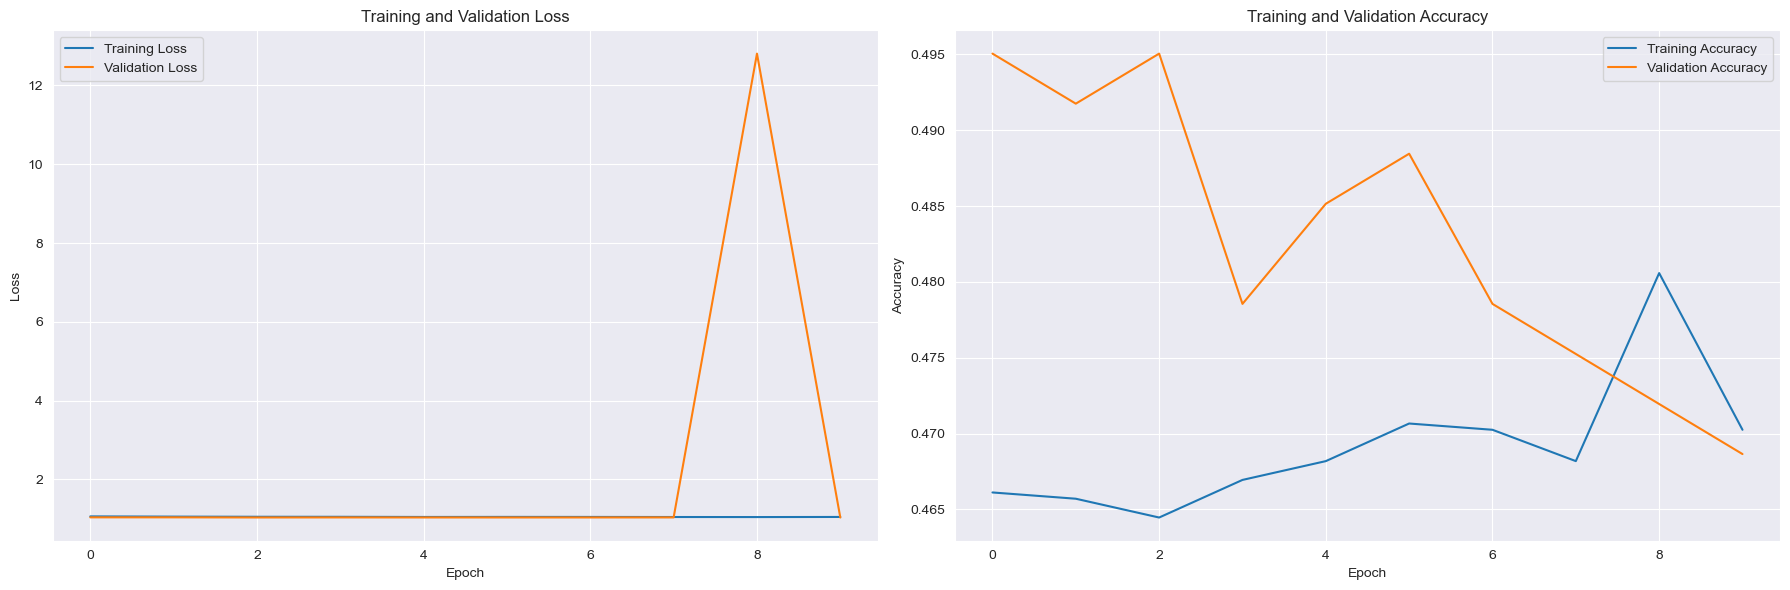

In [35]:
def plot_training_history(history, lr=None, model_name=None):
    # Plot training and validation loss
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    if lr is not None and 'lr' in history.params:
        # Plot learning rate
        plt.figure(figsize=(6, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='red')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()

    if model_name is not None:
        save_path = os.path.join('./plots/', model_name)
        plt.savefig(save_path)

    plt.tight_layout()
    plt.show()

# Plot training history using plot_training_history function
plot_training_history(history)


In [36]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)



10/10 [==============================] - 0s 10ms/step


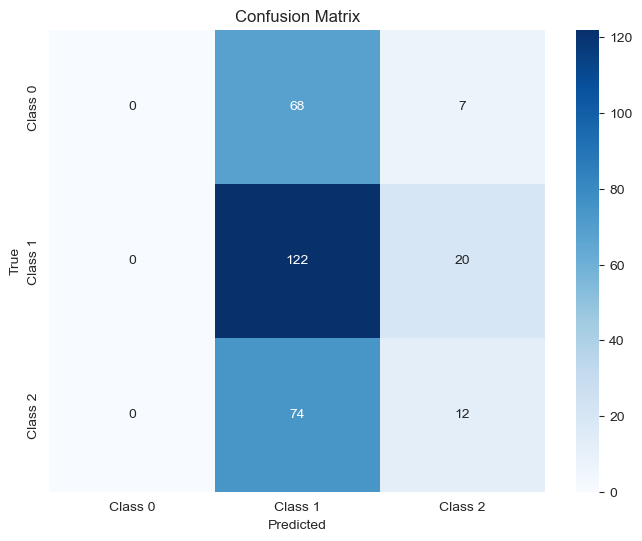

In [37]:
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [38]:
# Calculate precision, recall, and f1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

C:\Users\user\anaconda3\envs\spark-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# Create lists for labels and corresponding scores
labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


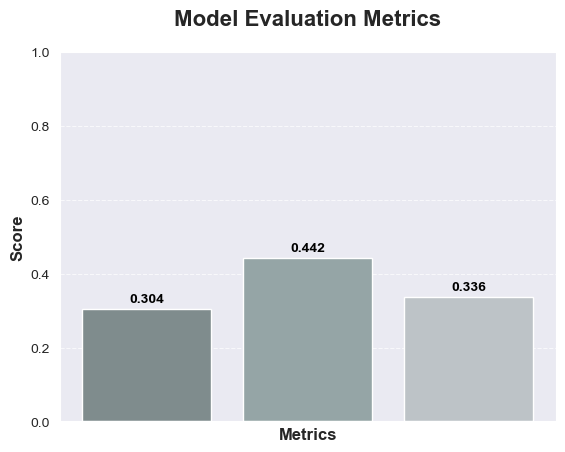

In [40]:
# Set a color palette for the bars (neutral colors)
colors = ['#7f8c8d', '#95a5a6', '#bdc3c7']

# Plotting the bar chart 
fig, ax = plt.subplots()
bars = ax.bar(labels, scores, color=colors)

# Adding data values above the bars with adjusted positioning
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

# Adding title and labels
plt.title('Model Evaluation Metrics', fontsize=16, fontweight='bold', y=1.05)  # Adjusted y position for title
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')

# Adjusting y-axis limits and grid
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Removing x-axis ticks
plt.xticks([])

# Display the plot
plt.show()

SVM Accuracy (C=0.001): 0.49, F1 Score: 0.50
SVM Accuracy (C=0.01): 0.54, F1 Score: 0.56
SVM Accuracy (C=0.1): 0.55, F1 Score: 0.57
SVM Accuracy (C=1): 0.55, F1 Score: 0.57
SVM Accuracy (C=10): 0.56, F1 Score: 0.57
SVM Accuracy (C=100): 0.56, F1 Score: 0.57


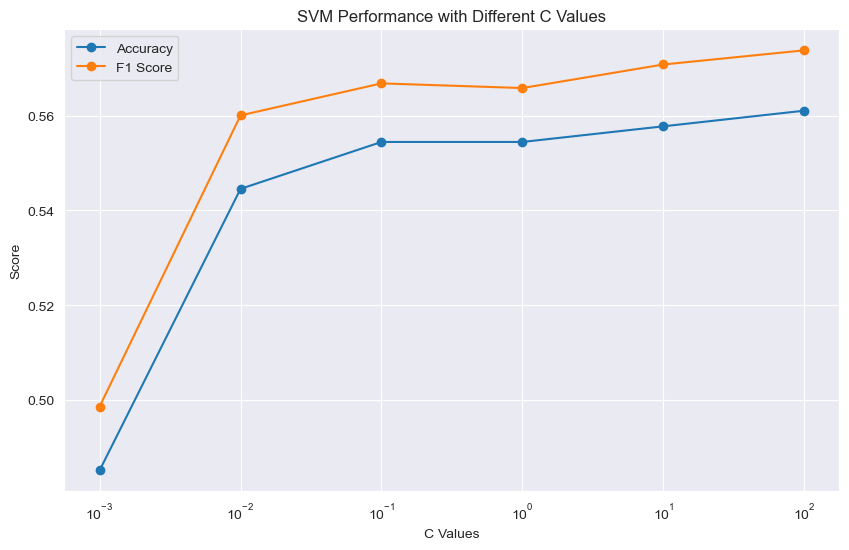

In [55]:
# List of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Lists to store results
accuracies = []
f1_scores = []

# Iterate through different C values
for c_value in C_values:
    # Build the SVM model
    svm_model = SVC(kernel='linear', C=c_value, class_weight='balanced')
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate the SVM model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # You can change 'weighted' to other options based on your preference

    # Append results to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)

    # Print the results for each C value
    print(f"SVM Accuracy (C={c_value}): {accuracy:.2f}, F1 Score: {f1:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, label='Accuracy', marker='o')
plt.plot(C_values, f1_scores, label='F1 Score', marker='o')
plt.xscale('log')  # Use a log scale for better visualization
plt.xlabel('C Values')
plt.ylabel('Score')
plt.title('SVM Performance with Different C Values')
plt.legend()
plt.show()

SVM Accuracy (C=0.001): 0.25, F1 Score: 0.10
SVM Accuracy (C=0.01): 0.37, F1 Score: 0.35
SVM Accuracy (C=0.1): 0.48, F1 Score: 0.49
SVM Accuracy (C=1): 0.53, F1 Score: 0.54
SVM Accuracy (C=10): 0.52, F1 Score: 0.52
SVM Accuracy (C=100): 0.45, F1 Score: 0.46


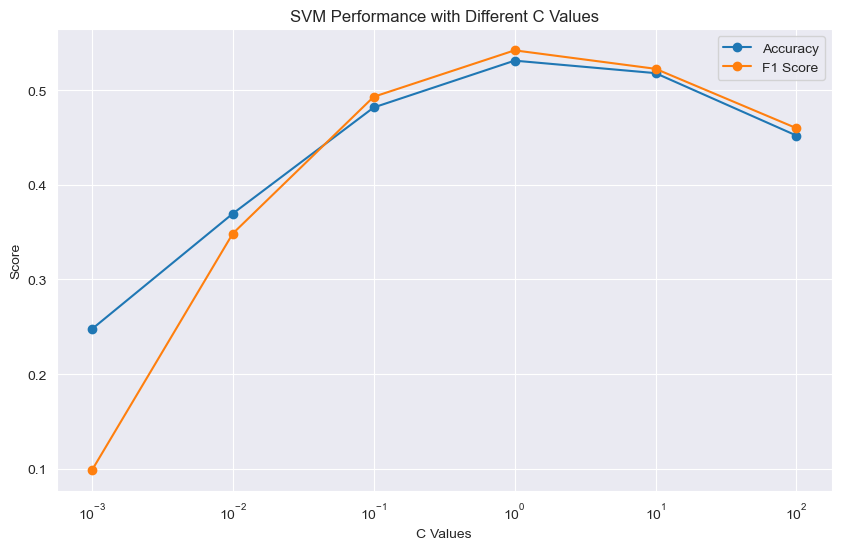

In [56]:
# List of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Lists to store results
accuracies = []
f1_scores = []

# Iterate through different C values
for c_value in C_values:
    # Build the SVM model
    svm_model = SVC(kernel='rbf', C=c_value, class_weight='balanced')
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate the SVM model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # You can change 'weighted' to other options based on your preference

    # Append results to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)

    # Print the results for each C value
    print(f"SVM Accuracy (C={c_value}): {accuracy:.2f}, F1 Score: {f1:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, label='Accuracy', marker='o')
plt.plot(C_values, f1_scores, label='F1 Score', marker='o')
plt.xscale('log')  # Use a log scale for better visualization
plt.xlabel('C Values')
plt.ylabel('Score')
plt.title('SVM Performance with Different C Values')
plt.legend()
plt.show()

SVM Accuracy (C=0.001): 0.28, F1 Score: 0.17
SVM Accuracy (C=0.01): 0.39, F1 Score: 0.38
SVM Accuracy (C=0.1): 0.44, F1 Score: 0.45
SVM Accuracy (C=1): 0.50, F1 Score: 0.51
SVM Accuracy (C=10): 0.48, F1 Score: 0.49
SVM Accuracy (C=100): 0.45, F1 Score: 0.46


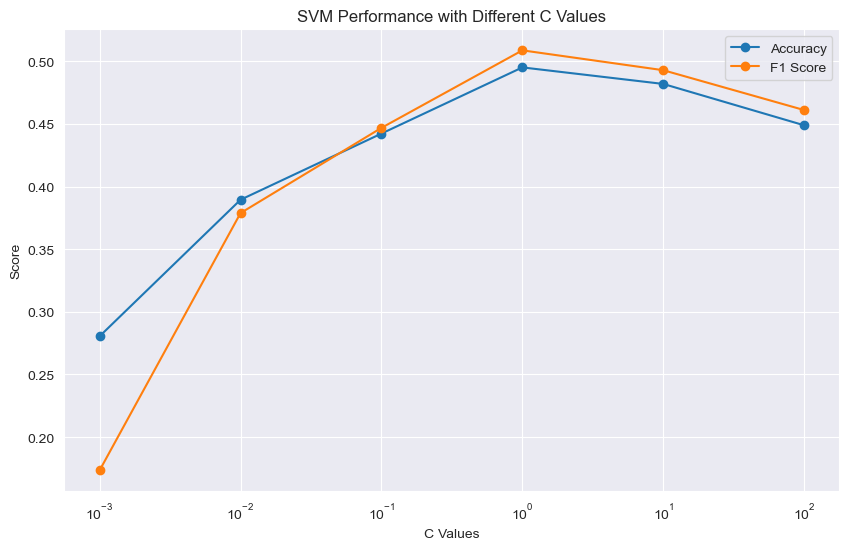

In [57]:
# List of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Lists to store results
accuracies = []
f1_scores = []

# Iterate through different C values
for c_value in C_values:
    # Build the SVM model
    svm_model = SVC(kernel='poly', C=c_value, class_weight='balanced')
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate the SVM model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # You can change 'weighted' to other options based on your preference

    # Append results to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)

    # Print the results for each C value
    print(f"SVM Accuracy (C={c_value}): {accuracy:.2f}, F1 Score: {f1:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, label='Accuracy', marker='o')
plt.plot(C_values, f1_scores, label='F1 Score', marker='o')
plt.xscale('log')  # Use a log scale for better visualization
plt.xlabel('C Values')
plt.ylabel('Score')
plt.title('SVM Performance with Different C Values')
plt.legend()
plt.show()

Random Forest Accuracy (n_estimators=50): 0.56, F1 Score: 0.54
Random Forest Accuracy (n_estimators=100): 0.56, F1 Score: 0.52
Random Forest Accuracy (n_estimators=150): 0.56, F1 Score: 0.52
Random Forest Accuracy (n_estimators=200): 0.56, F1 Score: 0.52


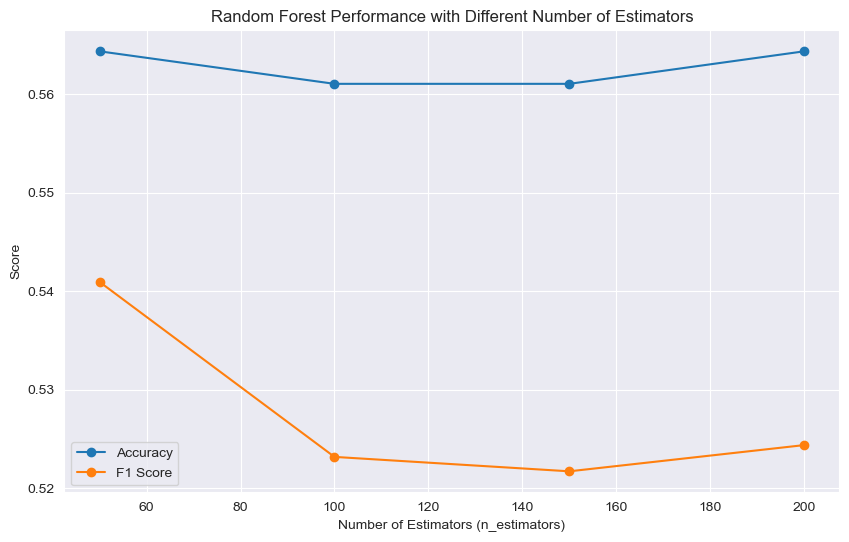

In [58]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# List of n_estimators values to try
n_estimators_values = [50, 100, 150, 200]

# Lists to store results
accuracies_rf = []
f1_scores_rf = []

# Iterate through different n_estimators values
for n_estimators_value in n_estimators_values:
    # Build the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_rf = rf_model.predict(X_test)

    # Evaluate the Random Forest model
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    f1_rf = f1_score(y_test, y_pred_rf, average='weighted')  # You can change 'weighted' to other options based on your preference

    # Append results to the lists
    accuracies_rf.append(accuracy_rf)
    f1_scores_rf.append(f1_rf)

    # Print the results for each n_estimators value
    print(f"Random Forest Accuracy (n_estimators={n_estimators_value}): {accuracy_rf:.2f}, F1 Score: {f1_rf:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, accuracies_rf, label='Accuracy', marker='o')
plt.plot(n_estimators_values, f1_scores_rf, label='F1 Score', marker='o')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Score')
plt.title('Random Forest Performance with Different Number of Estimators')
plt.legend()
plt.show()


XGBoost Accuracy (n_estimators=50): 0.56, F1 Score: 0.54
XGBoost Accuracy (n_estimators=100): 0.57, F1 Score: 0.55
XGBoost Accuracy (n_estimators=150): 0.55, F1 Score: 0.54
XGBoost Accuracy (n_estimators=200): 0.57, F1 Score: 0.56


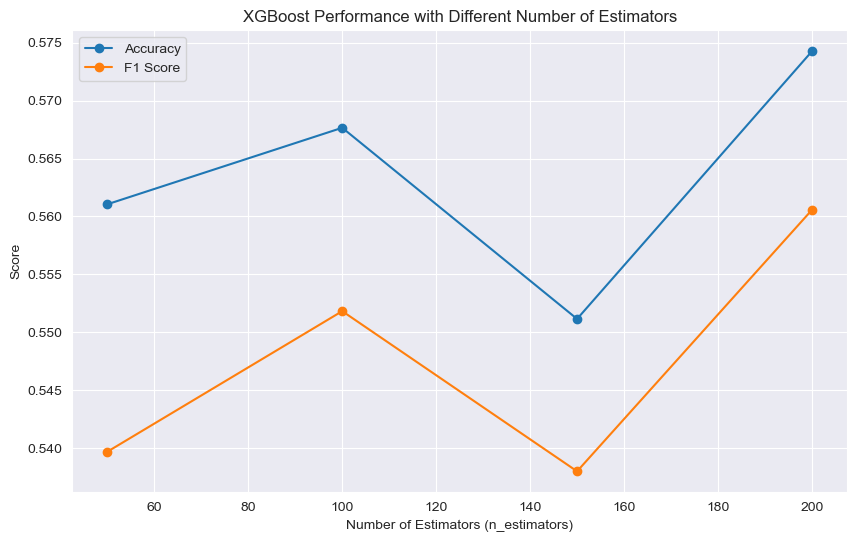

In [60]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# List of n_estimators values to try
n_estimators_values = [50, 100, 150, 200]

# Lists to store results
accuracies_xgboost = []
f1_scores_xgboost = []

# Iterate through different n_estimators values
for n_estimators_value in n_estimators_values:
    # Build the XGBoost model
    xgb_model = XGBClassifier(n_estimators=n_estimators_value, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_xgboost = xgb_model.predict(X_test)

    # Evaluate the XGBoost model
    accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
    f1_xgboost = f1_score(y_test, y_pred_xgboost, average='weighted')  # You can change 'weighted' to other options based on your preference

    # Append results to the lists
    accuracies_xgboost.append(accuracy_xgboost)
    f1_scores_xgboost.append(f1_xgboost)

    # Print the results for each n_estimators value
    print(f"XGBoost Accuracy (n_estimators={n_estimators_value}): {accuracy_xgboost:.2f}, F1 Score: {f1_xgboost:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, accuracies_xgboost, label='Accuracy', marker='o')
plt.plot(n_estimators_values, f1_scores_xgboost, label='F1 Score', marker='o')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Score')
plt.title('XGBoost Performance with Different Number of Estimators')
plt.legend()
plt.show()


In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate

# Define the input layer
input_layer = Input(shape=(X_train.shape[1],))

# Define the deep path
deep_path = Dense(128, activation='relu')(input_layer)
deep_path = Dense(64, activation='relu')(deep_path)
deep_path = Dense(32, activation='relu')(deep_path)

# Define the wide path (using the original input)
wide_path = Dense(32, activation='relu')(input_layer)

# Concatenate the deep and wide paths
combined = concatenate([deep_path, wide_path])

# Output layer
output_layer = Dense(3, activation='softmax')(combined)  # Adjust the number of units based on your problem

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 128)                  4352      ['input_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 64)                   8256      ['dense_2[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 32)                   2080      ['dense_3[0][0]']             
                                                                                              

In [62]:
model_path_ann = './models/avg_stats_ann_model'

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks (optional but useful)
checkpoint = ModelCheckpoint(model_path_ann, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model and store the history
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val_categorical),
                    callbacks=[checkpoint, early_stopping])




Epoch 1/50
58/76 [=====================>........] - ETA: 0s - loss: 0.0937 - accuracy: 0.9806
Epoch 1: val_loss improved from inf to 2.67202, saving model to ./models\avg_stats_ann_model
76/76 [==============================] - 0s 5ms/step - loss: 0.0984 - accuracy: 0.9806 - val_loss: 2.6720 - val_accuracy: 0.4818
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9872
Epoch 2: val_loss did not improve from 2.67202
76/76 [==============================] - 0s 4ms/step - loss: 0.0892 - accuracy: 0.9872 - val_loss: 2.7515 - val_accuracy: 0.4719
Epoch 3/50
74/76 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9789
Epoch 3: val_loss did not improve from 2.67202
76/76 [==============================] - 0s 4ms/step - loss: 0.0897 - accuracy: 0.9793 - val_loss: 2.9718 - val_accuracy: 0.4686
Epoch 4/50
73/76 [===========================>..] - ETA: 0s - loss: 0.0922 - accuracy: 0.9777
Epoch 4: val_loss did not improve from 2.67202
76/

In [64]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test_categorical)[1]
print(f"Test Accuracy: {accuracy:.2f}")

10/10 [==============================] - 0s 3ms/step - loss: 2.4842 - accuracy: 0.4785
Test Accuracy: 0.48


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# LSTM model with Dropout and L2 Regularization
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))  # Add dropout layer with 50% dropout rate
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(Dropout(0.5))  # Add dropout layer with 50% dropout rate
model.add(Dense(3, activation='softmax'))

# Compile the model with 'categorical_crossentropy' loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val_categorical), callbacks=[checkpoint])



Epoch 1/100
75/76 [============================>.] - ETA: 0s - loss: 1.7418 - accuracy: 0.4571
Epoch 1: val_loss improved from 2.67202 to 1.31530, saving model to ./models\avg_stats_ann_model
76/76 [==============================] - 4s 28ms/step - loss: 1.7384 - accuracy: 0.4570 - val_loss: 1.3153 - val_accuracy: 0.4950
Epoch 2/100
75/76 [============================>.] - ETA: 0s - loss: 1.1930 - accuracy: 0.4688
Epoch 2: val_loss improved from 1.31530 to 1.09886, saving model to ./models\avg_stats_ann_model
76/76 [==============================] - 2s 29ms/step - loss: 1.1929 - accuracy: 0.4678 - val_loss: 1.0989 - val_accuracy: 0.4950
Epoch 3/100
75/76 [============================>.] - ETA: 0s - loss: 1.0856 - accuracy: 0.4688
Epoch 3: val_loss improved from 1.09886 to 1.05606, saving model to ./models\avg_stats_ann_model
76/76 [==============================] - 2s 24ms/step - loss: 1.0850 - accuracy: 0.4682 - val_loss: 1.0561 - val_accuracy: 0.4950
Epoch 4/100
74/76 [===============

In [69]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test_categorical)[1]
print(f"Test Accuracy: {accuracy:.2f}")

10/10 [==============================] - 0s 11ms/step - loss: 0.9718 - accuracy: 0.5446
Test Accuracy: 0.54
